# The Relation Between Runs and Wins

### *Data*
We use baseball data from [Lahman Basebaball Database](http://www.seanlahman.com/) and [Retrosheet](https://www.retrosheet.org/). 
- Just to reproduce what's in the code, <font color="red">I included the data files needed for reproducing the plots in the repo already.</font> I have them stored under `data` folder in the same directory as this notebook. If you're interested in getting all the data in Lahman Database or Retrosheet, please refer to the following 2 bullet points. 
- You can manually download CSV files from [Lahman Baseball Database](https://www.dropbox.com/scl/fi/hy0sxw6gaai7ghemrshi8/lahman_1871-2023_csv.7z?rlkey=edw1u63zzxg48gvpcmr3qpnhz&e=1&dl=0). 
- You can also download retrosheet data in CSV files. This process can be a bit tricky. I followed [this process](https://github.com/davidbmitchell/Baseball-PostgreSQL) to download the CSV files. If you're on mac, I created a shell script you may use for downloading the retrosheet data. Note that you'll need to change the file/folder path in the script. 
### *Packages*
- We use `polars`, `plotnine`, `statsmodels`, and `adjustText` in this notebook. Make sure to download them via your package manager. 
### *Description of the viz*
- We recreate a few visualizations found in [Chapter 4: The Relation Between Runs and Wins - Analyzing Baseball Data with R (3e)](https://beanumber.github.io/abdwr3e/04-pythagoras.html).

### *References*
- [Chapter 4: The Relation Between Runs and Wins - Analyzing Baseball Data with R (3e)](https://beanumber.github.io/abdwr3e/04-pythagoras.html)

## 0. Import libraries

In [1]:
# !pip install polars
# !pip install plotnine

In [2]:
import polars as pl
from plotnine import *

## 1. Get historical statistics for each team

In [3]:
teams = pl.read_csv('data/lahman/Teams.csv')

In [4]:
teams.tail()

yearID,lgID,teamID,franchID,divID,Rank,G,Ghome,W,L,DivWin,WCWin,LgWin,WSWin,R,AB,H,2B,3B,HR,BB,SO,SB,CS,HBP,SF,RA,ER,ERA,CG,SHO,SV,IPouts,HA,HRA,BBA,SOA,E,DP,FP,name,park,attendance,BPF,PPF,teamIDBR,teamIDlahman45,teamIDretro
i64,str,str,str,str,i64,i64,str,i64,i64,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,str,i64,i64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,str,str,str,i64,i64,str,str,str
2023,"""NL""","""PIT""","""PIT""","""C""",4,162,"""81""",76,86,"""N""","""N""","""N""","""N""",692,5406,1293,287,31,159,556,1464,117,41,"""58""","""43""",790,731,4.6,2,2,47,4290,1380,179,596,1363,91,360,0.984,"""Pittsburgh Pirates""","""PNC Park""","""1630624""",99,101,"""PIT""","""PIT""","""PIT"""
2023,"""NL""","""SDN""","""SDP""","""W""",3,162,"""81""",82,80,"""N""","""N""","""N""","""N""",752,5401,1316,273,14,205,653,1311,137,32,"""57""","""44""",648,598,3.73,0,0,36,4323,1270,174,557,1445,73,356,0.988,"""San Diego Padres""","""PETCO Park""","""3271554""",94,93,"""SDP""","""SDN""","""SDN"""
2023,"""NL""","""SFN""","""SFG""","""W""",4,162,"""81""",79,83,"""N""","""N""","""N""","""N""",674,5412,1271,256,13,174,544,1492,57,16,"""81""","""39""",719,641,4.02,4,2,50,4304,1395,173,403,1359,117,399,0.981,"""San Francisco Giants""","""AT&T Park""","""2500153""",96,96,"""SFG""","""SFN""","""SFN"""
2023,"""NL""","""SLN""","""STL""","""C""",5,162,"""81""",71,91,"""N""","""N""","""N""","""N""",719,5510,1376,264,12,209,570,1326,101,29,"""70""","""37""",829,760,4.79,0,0,36,4285,1549,179,530,1215,67,431,0.989,"""St. Louis Cardinals""","""Busch Stadium III""","""3241091""",99,99,"""STL""","""SLN""","""SLN"""
2023,"""NL""","""WAS""","""WSN""","""E""",5,162,"""81""",71,91,"""N""","""N""","""N""","""N""",700,5522,1401,279,26,151,423,1149,127,29,"""78""","""38""",845,797,5.02,0,0,42,4285,1512,245,592,1225,90,430,0.985,"""Washington Nationals""","""Nationals Park""","""1865832""",96,98,"""WSN""","""MON""","""WAS"""


## 2. Calculate Run Differentials and Winning Percentage for all the seasons after 2000
- `RD (Run Differential)` is calculated by `Runs` - `Runs Allows`

In [5]:
my_teams = (
    teams
    .filter(pl.col('yearID')>2000)
    .select('teamID', 'yearID', 'lgID', 'G', 'W', 'L', 'R', 'RA')
    .with_columns(
        RD=pl.col('R') - pl.col('RA'),
        Wpct=pl.col('W') / (pl.col('W') + pl.col('L'))
    )
)

my_teams.tail()

teamID,yearID,lgID,G,W,L,R,RA,RD,Wpct
str,i64,str,i64,i64,i64,i64,i64,i64,f64
"""PIT""",2023,"""NL""",162,76,86,692,790,-98,0.469136
"""SDN""",2023,"""NL""",162,82,80,752,648,104,0.506173
"""SFN""",2023,"""NL""",162,79,83,674,719,-45,0.487654
"""SLN""",2023,"""NL""",162,71,91,719,829,-110,0.438272
"""WAS""",2023,"""NL""",162,71,91,700,845,-145,0.438272


## 3. Analyze the relationship between Run Differential and Winning Percentage with a linear model

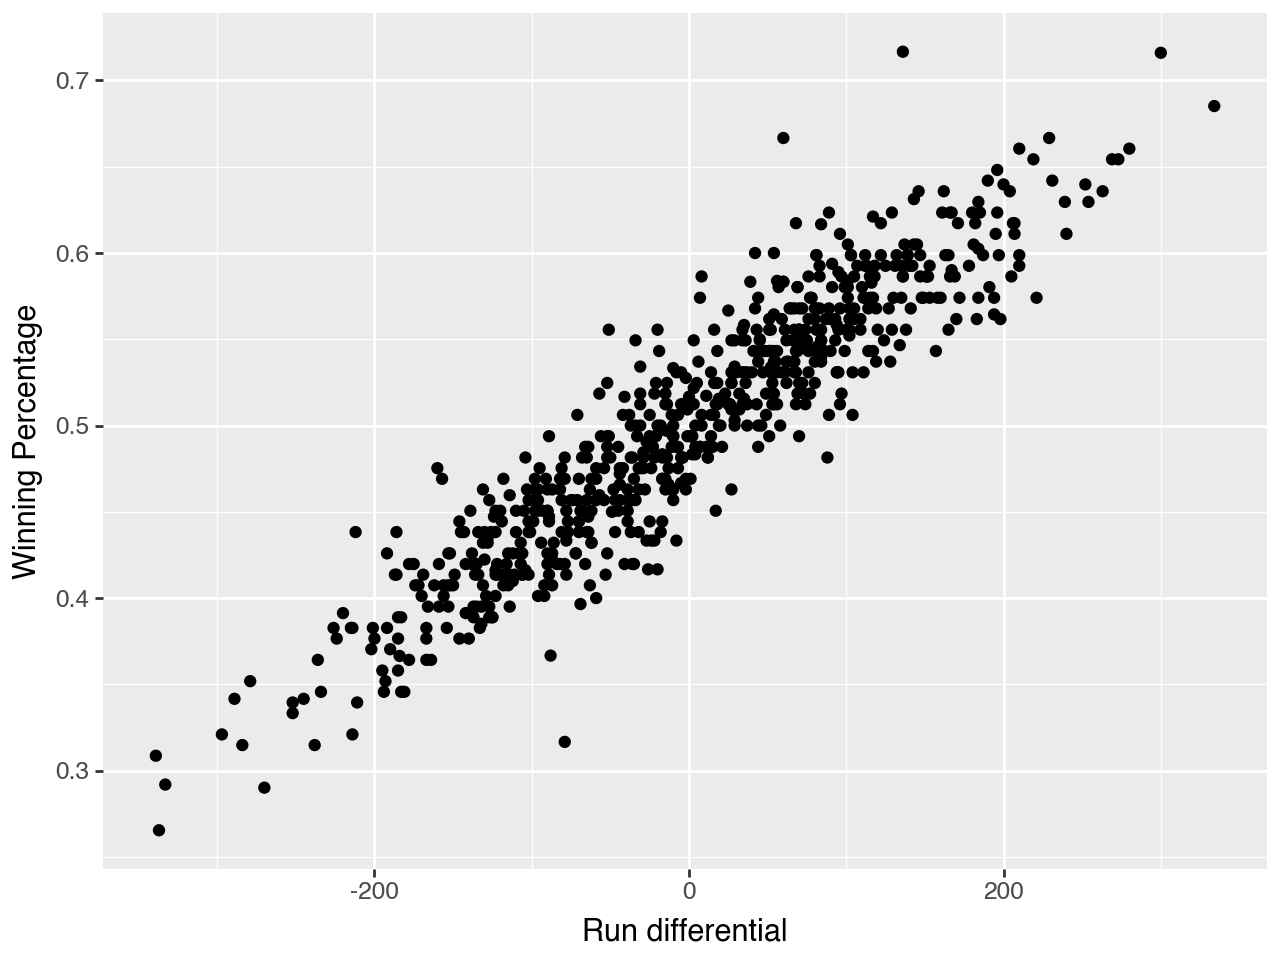

In [6]:
run_diff = (
    ggplot(my_teams, aes(x='RD', y='Wpct')) 
    + geom_point() 
    + xlab('Run differential') 
    + ylab('Winning Percentage')
)

run_diff

In [7]:
import statsmodels.api as sm

y = my_teams.select('Wpct').to_numpy()
x = my_teams.select('RD').to_numpy()

model = sm.OLS(y, sm.add_constant(x))
linfit = model.fit()

linfit.summary(), linfit.params

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                      y   R-squared:                       0.864
 Model:                            OLS   Adj. R-squared:                  0.863
 Method:                 Least Squares   F-statistic:                     4354.
 Date:                Thu, 25 Jul 2024   Prob (F-statistic):          9.08e-300
 Time:                        16:31:55   Log-Likelihood:                 1487.8
 No. Observations:                 690   AIC:                            -2972.
 Df Residuals:                     688   BIC:                            -2962.
 Df Model:                           1                                         
 Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
 ---------------------------------------------------------------------

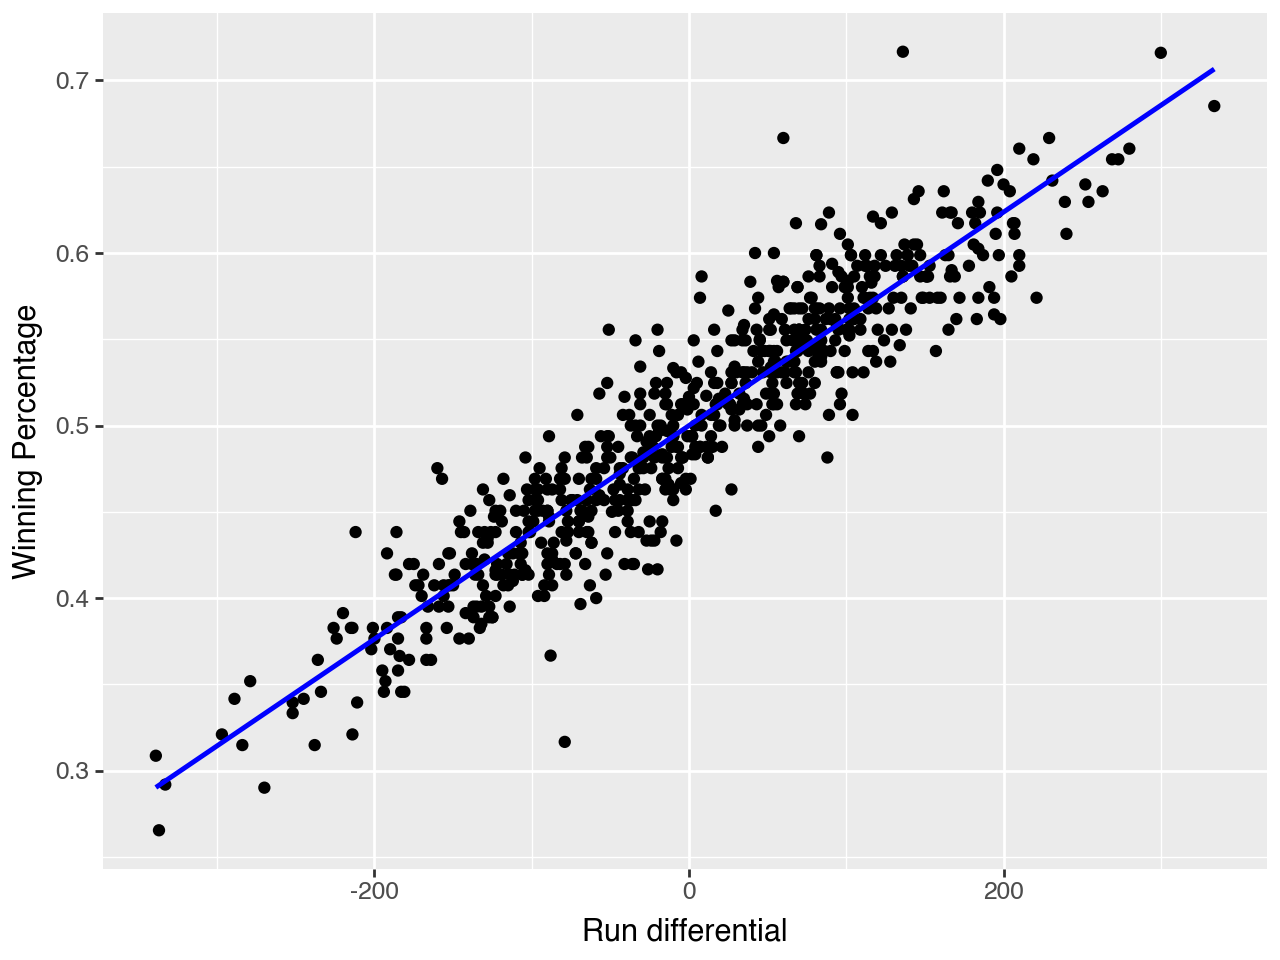

In [8]:
(
    run_diff + 
    geom_smooth(method='lm', se=False, color='blue')
)

So easy to add a linear line with `method=lm`!!!

## 4. Plot the residuals against the Run Differential

In [9]:
my_teams_aug = (
    my_teams
    .with_columns(
        pl.from_numpy(linfit.resid).to_series().alias('Resid')
    )
)

In [10]:
base_plot = (
    ggplot(my_teams_aug, aes(x='RD', y='Resid'))
    + geom_point(alpha=0.3)
    + geom_hline(yintercept=0, linetype='dashed')
    + xlab('Run differential') + ylab('Residual')
)

In [11]:
highlight_teams = (
    my_teams_aug
    .sort(abs(pl.col('Resid')), descending=True)
    .head(4)
)

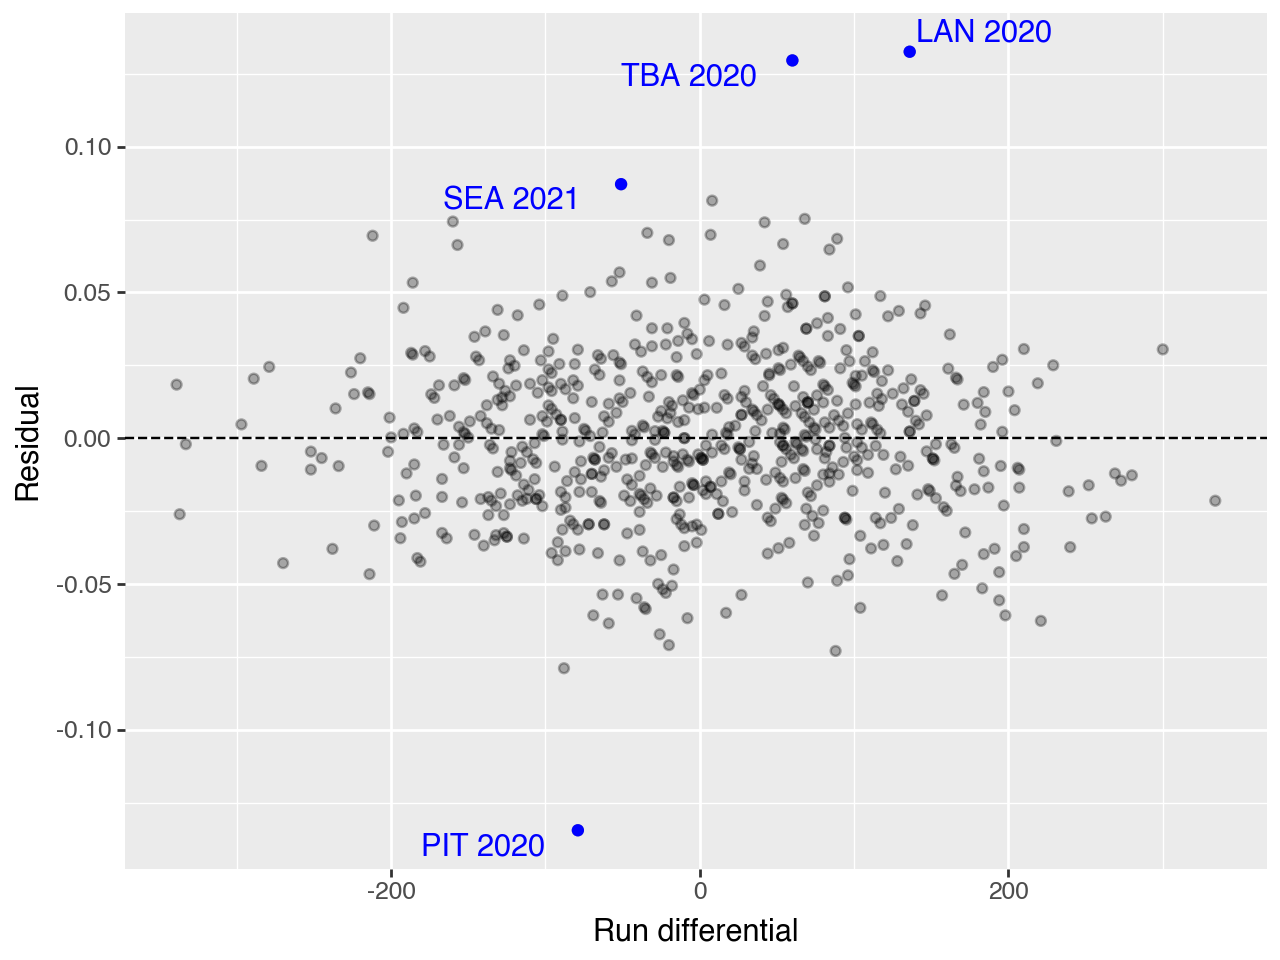

In [12]:
(
    base_plot 
    + geom_point(data=highlight_teams, color='blue') 
    + geom_text(
        data=highlight_teams, color='blue',
        label=highlight_teams['teamID'] + ' ' + highlight_teams['yearID'],
        adjust_text={
            'expand': (1.5, 1),
            'min_arrow_len': 100
        }, 
    )
)